https://www.kaggle.com/code/mehmetlaudatekman/text-classification-svm-explained

# Importo le librerie che mi serviranno

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import time
import re

# Importo il dataset con i tweet con l'hastag #coronavirus

In [2]:
train_set = pd.read_csv('dataset_nlp/Corona_NLP_train.csv',encoding="latin1")
test_set = pd.read_csv('dataset_nlp/Corona_NLP_test.csv',encoding="latin1")

train_set.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

# Mantengo solo le variabili che mi interessano

In [3]:
unrelevant_features = ["UserName","ScreenName","Location","TweetAt"]

train_set.drop(unrelevant_features,inplace=True,axis=1)
test_set.drop(unrelevant_features,inplace=True,axis=1)
train_set.head()

OriginalTweet           Sentiment
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1  advice Talk to your neighbours family to excha...            Positive
2  Coronavirus Australia: Woolworths to give elde...            Positive
3  My food stock is not the only one which is emp...            Positive
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [4]:
train_set["Sentiment"].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

# Diminuisco il numero di categorie di target

In [5]:
positives = train_set[(train_set["Sentiment"] == "Positive") | (train_set["Sentiment"] == "Extremely Positive")]
positives_test = test_set[(test_set["Sentiment"] == "Positive") | (test_set["Sentiment"] == "Extremely Positive")]
print(positives["Sentiment"].value_counts())
positives.head()

Sentiment
Positive              11422
Extremely Positive     6624
Name: count, dtype: int64


OriginalTweet Sentiment
1  advice Talk to your neighbours family to excha...  Positive
2  Coronavirus Australia: Woolworths to give elde...  Positive
3  My food stock is not the only one which is emp...  Positive
5  As news of the regionÂs first confirmed COVID...  Positive
6  Cashier at grocery store was sharing his insig...  Positive

In [6]:
negatives = train_set[(train_set["Sentiment"] == "Negative") | (train_set["Sentiment"] == "Extremely Negative")]
negatives_test = test_set[(test_set["Sentiment"] == "Negative") | (test_set["Sentiment"] == "Extremely Negative")]
print(negatives["Sentiment"].value_counts())
negatives.head()

Sentiment
Negative              9917
Extremely Negative    5481
Name: count, dtype: int64


OriginalTweet           Sentiment
4   Me, ready to go at supermarket during the #COV...  Extremely Negative
9   For corona prevention,we should stop to buy th...            Negative
20  with 100  nations inficted with  covid  19  th...  Extremely Negative
24  @10DowningStreet @grantshapps what is being do...            Negative
26  In preparation for higher demand and a potenti...            Negative

In [7]:
neutrals = train_set[train_set["Sentiment"] == "Neutral"]
neutrals_test = test_set[test_set["Sentiment"] == "Neutral"]
print(neutrals["Sentiment"].value_counts())
neutrals.head()

Sentiment
Neutral    7713
Name: count, dtype: int64


OriginalTweet Sentiment
0   @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   Neutral
7   Was at the supermarket today. Didn't buy toile...   Neutral
10  All month there hasn't been crowding in the su...   Neutral
16  ????? ????? ????? ????? ??\r\r\n?????? ????? ?...   Neutral
17  @eyeonthearctic 16MAR20 Russia consumer survei...   Neutral

# Converto i testi in numeri

In [8]:
import warnings as wrn
wrn.filterwarnings('ignore')

negatives["Sentiment"] = 0
negatives_test["Sentiment"] = 0

positives["Sentiment"] = 2
positives_test["Sentiment"] = 2

neutrals["Sentiment"] = 1
neutrals_test["Sentiment"] = 1

negatives.head()

OriginalTweet  Sentiment
4   Me, ready to go at supermarket during the #COV...          0
9   For corona prevention,we should stop to buy th...          0
20  with 100  nations inficted with  covid  19  th...          0
24  @10DowningStreet @grantshapps what is being do...          0
26  In preparation for higher demand and a potenti...          0

# Ricreo il dataset

In [9]:
data = pd.concat([positives,
                  positives_test,
                  neutrals,
                  neutrals_test,
                  negatives,
                  negatives_test
                 ],axis=0)

data.reset_index(inplace=True)

In [10]:
data.head()

index                                      OriginalTweet  Sentiment
0      1  advice Talk to your neighbours family to excha...          2
1      2  Coronavirus Australia: Woolworths to give elde...          2
2      3  My food stock is not the only one which is emp...          2
3      5  As news of the regionÂs first confirmed COVID...          2
4      6  Cashier at grocery store was sharing his insig...          2

# Do un occhiata ai dati che devo elaborare

In [11]:
import random
for i in range(1,10):
    random_ind = random.randint(0,len(data))
    print(str(data["OriginalTweet"][random_ind]),end="\nLabel: ")
    print(str(data["Sentiment"][random_ind]),end="\n\n")



#coronavirus #covid19 #humor #quarantine https://t.co/GhN504BuCE
Label: 2



https://t.co/Fk0czQSwOJ
Label: 2









This is the time. Let's talk!
Label: 0

COVID 19 economic impact checks will be delivered based on 2018 2019 tax return information so no action is required for most people If you ve received your refunds via check in the past a check will be mailed to you There is no need to pre qualify
Label: 0







via @abdbozkurt #BREAKING https://t.co/45KNtwEeaE
Label: 0



#toiletpaper #toiletpapers #toiletpaperchallenge #toiletpapercrisis #toiletpapercheap #coronavirus #coronavirustips #help
Label: 1

How the is wreaking havoc for divorcing couples
Label: 0

It's almost certain that Trump is more focused on energy markets than NY #coronavirus statistics today. Watch how enthusiastically and engaged he answers any questions on this topic (oil prices) vs. the #pandemic today.
Label: 2

 Further Covid 19 information   Avoid the supermarket queues
Label: 0



# Quali sono i termini più usati? Vengono usati termini differenti per differente variabile di target?

In [12]:
positiveFD = nltk.FreqDist(word for text in data[data["Sentiment"] == 2]["OriginalTweet"] for word in text.lower().split())
negativeFD = nltk.FreqDist(word  for text in data[data["Sentiment"] == 0]["OriginalTweet"] for word in text.lower().split())
neutralDF = nltk.FreqDist(word  for text in data[data["Sentiment"] == 1]["OriginalTweet"] for word in text.lower().split())

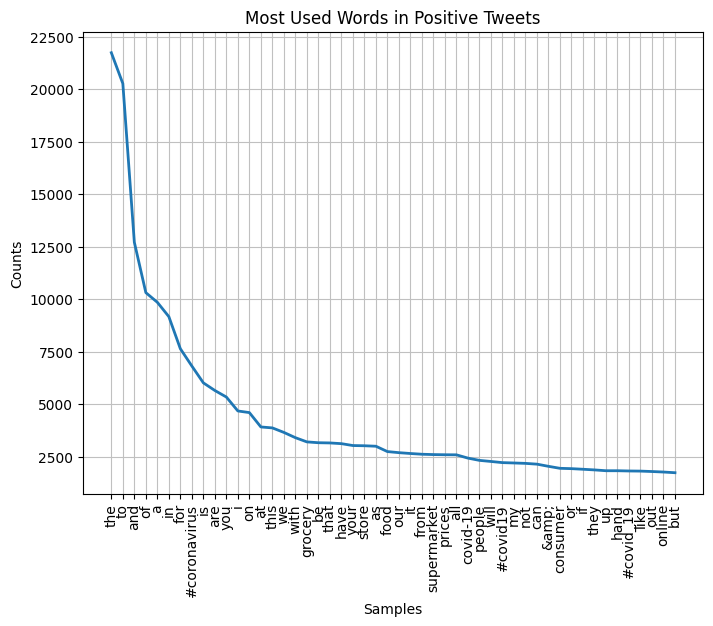

In [13]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Positive Tweets")
positiveFD.plot(50)
plt.show()

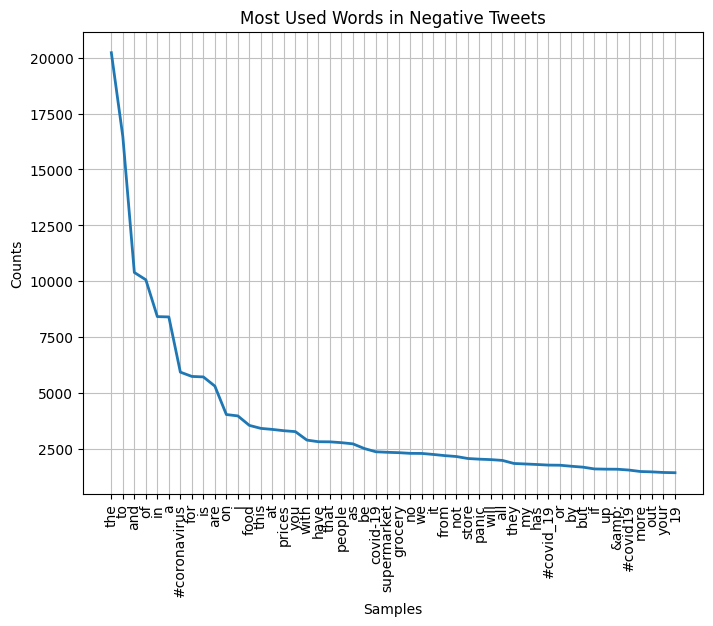

In [14]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Negative Tweets")
negativeFD.plot(50)
plt.show()

# Dobbiamo pulire questi testi per facilitare l'algoritmo nel suo compito di classificazione

# Pulizia e trasformazione dei dati in modo che siano elaborabili matematicamente

* Cleaning Links: We'll clean all website links using regular expressions
* Cleaning Everything Except Alphabetical and Numerical Characters: We'll clean unrelevant digits using regular expressions
* Tokenizing and Lemmatizing: We'll split texts into their words and convert words to their base form (dogs=>dog)
* Removing Stopwords: We'll remove words that have no special meaning (such as the,will,was)
* Joining Prepared Strings: We'll join the words
* Bag of Words Approach: We'll create a bag of word. In bag of words approach each feature shows whether the text contains the word or not. For instance if our text contains grocery word, its grocery feature will be 1 if not it will be 0.

![image-2.png](attachment:image-2.png)

In [19]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
cleanedData = []

nltk.download("stopwords") # This line downloads the stopwords if needed
nltk.download('punkt_tab') # This line downloads the punkt tokenizer if needed
nltk.download('wordnet')   # This line downloads WordNet if needed

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data["OriginalTweet"]:

    # Cleaning links
    text = re.sub(r'http\S+', '', text)

    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)

    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]

    # Removing stopwords
    text = [word for word in text if word not in swords]

    # Joining
    text = " ".join(text)

    cleanedData.append(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
for i in range(0,5):
    print(str(i), data["OriginalTweet"][i],end="\n\n")

0 advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order

1 Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P






#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j

3 As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU

4 Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented "I'm in Civics class so I know what I'm talking about". https://t.co/ieFDNeHgDO



In [28]:
for i in range(0,5):
    print(str(i), cleanedData[i],end="\n\n")

0 advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account poss adequate supply regular med order

1 coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid 19 outbreak

2 food stock one empty please panic enough food everyone take need stay calm stay safe covid19france covid 19 covid19 coronavirus confinement confinementotal confinementgeneral

3 news region first confirmed covid 19 case came sullivan county last week people flocked area store purchase cleaning supply hand sanitizer food toilet paper good tim dodson report

4 cashier grocery store wa sharing insight covid 19 prove credibility commented civics class know talking



# BOW Model
![image.png](attachment:image.png)

In [29]:
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)

In [30]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(data["Sentiment"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(33716, 10000)
(11239, 10000)
(33716,)
(11239,)


# APPLICO SVM

In [31]:
from sklearn.svm import SVC
start_time = time.time()

model = SVC(kernel='linear')
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

Fitting SVC took 916.68 seconds


In [32]:
predictions = model.predict(x_test)

In [33]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

Accuracy of model is 80.54097339620962%


# Proviamo con un kernel differente

In [34]:
model = SVC(kernel='rbf')
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

predictions = model.predict(x_test)

print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

Fitting SVC took 1633.99 seconds
Accuracy of model is 77.60476910757184%
